# Ритейл — Анализ программы лояльности

## Ознакомиться с данными, изучить структуру и формат представления.

In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import scipy.stats as stats
from scipy import stats as st
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
import math as mth
import plotly.express as px
from plotly import graph_objects as go
from datetime import datetime, timedelta

In [2]:
#код загрузки первого датасета

import os
    
rd = '/content/retail_dataset.csv'
if os.path.exists(rd):
    rd = pd.read_csv(rd)
else:
    print('Something is wrong')

rd.info()
display(rd.head(10));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0
5,538379,22965,0,2016-12-12 11:26:00,22805.0,Shop 0,1.0
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.0
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.0
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.0
9,539501,22372,0,2016-12-20 11:08:00,22764.0,Shop 0,1.0


In [3]:
#код загрузки второго датасета

import os
    
pc = '/content/product_codes.csv'
if os.path.exists(pc):
    pc = pd.read_csv(pc)
else:
    print('Something is wrong')

pc.info()
display(pc.head(10));

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39
5,22752,7.65
6,21730,4.25
7,22633,1.85
8,22632,1.85
9,84879,1.69


In [4]:
# Найдем количество магазинов: 
print('Количество магазинов:', rd['ShopID'].nunique())

Количество магазинов: 31


### Выводы: 

Общая информация о датасетах:
**Retail Dataset**
У нас 7 столбцов с данными. Максимальное количество строк 105335.

Всего в таблице представлен 31 магазин.

Большинство столбцов имеют тип: object и float64.

В столбце для времени покупки нужно будет изменить тип данных.
customer_id, loyalty_program - тоже изменим тип данных.

**Product_codes**

У нас 2 столбца с данными. Максимальное количество строк 9969.

Столбцы имеют тип: object и float64.

В обеих датасетах нужно будет привести названия столбцов к нижнему регистру.

### Привести названия столбцов к нижнему регистру. Проверить данные на наличие пропусков, выбросов, дубликатов.

In [5]:
# Изменение названий столбцов в первом датасете
rd = rd.rename(columns={'purchaseid': 'purchase_id', 'item_ID': 'item_id', 'Quantity': 'quantity','purchasedate': 'purchase_date',
                               'CustomerID': 'customer_id', 'ShopID': 'shop_id'})

# Изменение названий столбцов во втором датасете
pc = pc.rename(columns={'productID': 'product_id'})
display(rd.columns)
display(pc.columns)

Index(['purchase_id', 'item_id', 'quantity', 'purchase_date', 'customer_id',
       'shop_id', 'loyalty_program'],
      dtype='object')

Index(['product_id', 'price_per_one'], dtype='object')

In [6]:
# Изменяем тип данных
rd['purchase_date'] = pd.to_datetime(rd['purchase_date']).dt.date
rd['purchase_date'] = pd.to_datetime(rd['purchase_date'], format='%Y-%m-%d')
rd['loyalty_program'] = rd['loyalty_program'].round(0).astype('bool')
rd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      105335 non-null  object        
 1   item_id          105335 non-null  object        
 2   quantity         105335 non-null  int64         
 3   purchase_date    105335 non-null  datetime64[ns]
 4   customer_id      69125 non-null   float64       
 5   shop_id          105335 non-null  object        
 6   loyalty_program  105335 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 4.9+ MB


In [7]:
#Проверяем наличие явных дубликатов
print('Количество дубликатов:', rd.duplicated().sum())
print('Количество дубликатов:', pc.duplicated().sum())

Количество дубликатов: 1034
Количество дубликатов: 0


In [8]:
#Удаляем явные дубликаты
rd = rd.drop_duplicates()
rd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104301 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      104301 non-null  object        
 1   item_id          104301 non-null  object        
 2   quantity         104301 non-null  int64         
 3   purchase_date    104301 non-null  datetime64[ns]
 4   customer_id      68154 non-null   float64       
 5   shop_id          104301 non-null  object        
 6   loyalty_program  104301 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 5.7+ MB


In [9]:
#Проверяем наличие пропусков
pd.DataFrame(round(rd.isna().sum(),1)).style.background_gradient('coolwarm')

,0
purchase_id,0
item_id,0
quantity,0
purchase_date,0
customer_id,36147
shop_id,0
loyalty_program,0


В столбце customer_id большое кол-во пропусков, удалять такое кол-во нельзя.
Пропущенные значения в 'customer_id', я думаю означают отсутствие информации о клиентах, заменим их на уникальное значение, которое не встречается в остальных идентификаторах клиентов.
Также проверим, есть ли среди пропусков участники программы лояльности.

In [10]:
# Подсчет количества пропущенных значений в customer_id среди участников программы лояльности
missing_count = rd.loc[rd['loyalty_program'] == 1, 'customer_id'].isna().sum()

print(f"Количество пропущенных значений в customer_id среди участников программы лояльности: {missing_count}")

Количество пропущенных значений в customer_id среди участников программы лояльности: 0


In [11]:
# Заменяем пропущенные значения на 0, которое не встречается в остальных идентификаторах клиентов.
rd['customer_id'] = rd['customer_id'].fillna(0)
rd['customer_id'] = rd['customer_id'].astype('int')
pd.DataFrame(round(rd.isna().sum(),1)).style.background_gradient('coolwarm')

,0
purchase_id,0
item_id,0
quantity,0
purchase_date,0
customer_id,0
shop_id,0
loyalty_program,0


In [12]:
#Проверяем наличие пропущенных значений во втором датасете
pd.DataFrame(round(pc.isna().sum(),1)).style.background_gradient('coolwarm')

,0
product_id,0
price_per_one,0


In [13]:
#Проверяем количество неявных дубликатов
print('Количество дубликатов:', pc['product_id'].duplicated().sum())

Количество дубликатов: 6810


In [14]:
#Заменяем неявные дубликаты на среднее значение
pc = pc.groupby('product_id')['price_per_one'].mean().reset_index()
display(pc)

,product_id,price_per_one
0,10002,1.380
1,10080,0.850
2,10120,0.210
3,10123C,0.650
4,10124A,0.420
...,...,...
3154,gift_0001_20,16.845
3155,gift_0001_30,25.265
3156,gift_0001_40,34.040
3157,gift_0001_50,42.550


### Выводы: 
Пропуски и дубликаты проверили и заполнили.

### Объединим таблицы

In [15]:
# Объединение таблиц retail_dataset и product_codes по столбцу item_ID
df = rd.merge(pc, left_on='item_id', right_on='product_id', how='left')

In [16]:
# Добавим столбец 'revenue' с выручкой
df = df.assign(revenue=df['quantity'] * df['price_per_one'])
# Вывод результата объединения
display(df.info())
display(df.head())
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104301 entries, 0 to 104300
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   purchase_id      104301 non-null  object        
 1   item_id          104301 non-null  object        
 2   quantity         104301 non-null  int64         
 3   purchase_date    104301 non-null  datetime64[ns]
 4   customer_id      104301 non-null  int64         
 5   shop_id          104301 non-null  object        
 6   loyalty_program  104301 non-null  bool          
 7   product_id       104301 non-null  object        
 8   price_per_one    104301 non-null  float64       
 9   revenue          104301 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 8.1+ MB


None

,purchase_id,item_id,quantity,purchase_date,customer_id,shop_id,loyalty_program,product_id,price_per_one,revenue
0,538280,21873,11,2016-12-10,18427,Shop 0,False,21873,1.810000,19.910
1,538862,22195,0,2016-12-14,22389,Shop 0,True,22195,2.766667,0.000
2,538855,21239,7,2016-12-14,22182,Shop 0,True,21239,1.474000,10.318
3,543543,22271,0,2017-02-09,23522,Shop 0,True,22271,4.300000,0.000
4,543812,79321,0,2017-02-13,23151,Shop 0,True,79321,7.013636,0.000


,quantity,customer_id,price_per_one,revenue
count,104301.000000,104301.000000,104301.000000,104301.000000
mean,7.883069,13729.446506,5.951259,19.156809
std,329.567119,10100.216183,96.290008,451.811458
min,-74216.000000,0.000000,0.000000,-77184.640000
25%,0.000000,0.000000,1.796667,0.000000
50%,2.000000,19423.000000,2.948333,5.940000
75%,7.000000,21692.000000,5.274000,19.125000
max,74214.000000,23962.000000,9268.762222,77182.560000


In [17]:
df.shape[0]

104301

#### Посмотрим на аномальные значения.

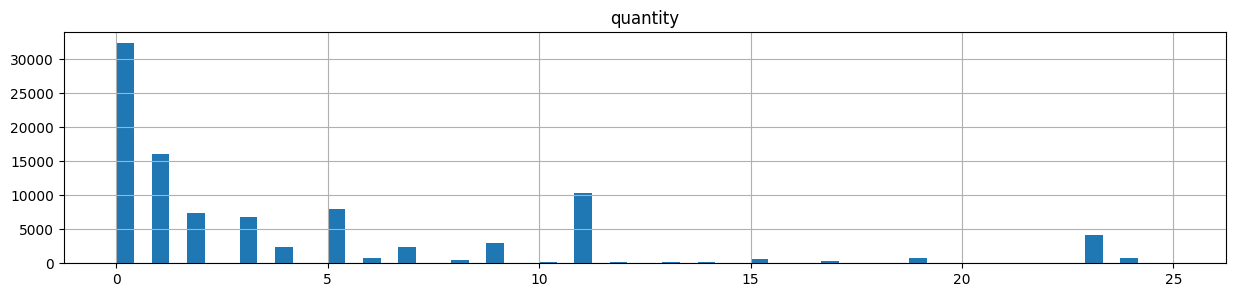

In [18]:
# check
df.hist(column = 'quantity', bins = 60, figsize = (15,3), range = (0,25));

In [19]:
# Изучим столбец quantity
df['quantity'].describe()

count    104301.000000
mean          7.883069
std         329.567119
min      -74216.000000
25%           0.000000
50%           2.000000
75%           7.000000
max       74214.000000
Name: quantity, dtype: float64

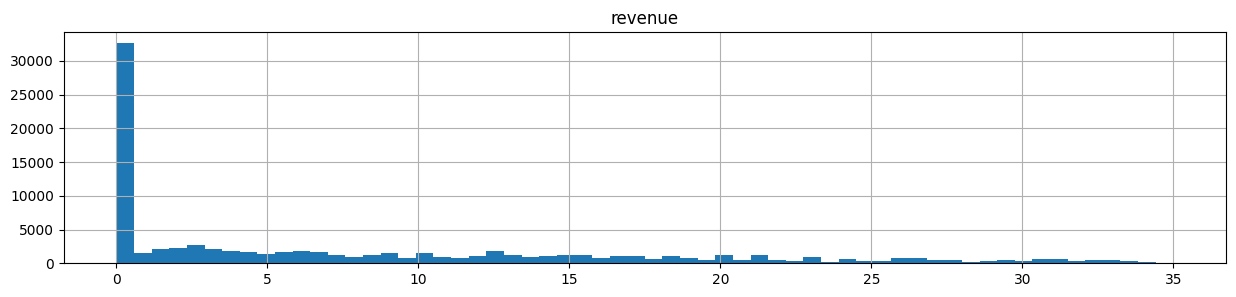

In [20]:
# check
df.hist(column = 'revenue', bins = 60, figsize = (15,3), range = (0,35));

In [21]:
# Изучим столбец quantity
df['revenue'].describe()

count    104301.000000
mean         19.156809
std         451.811458
min      -77184.640000
25%           0.000000
50%           5.940000
75%          19.125000
max       77182.560000
Name: revenue, dtype: float64

In [22]:
#Проверил количество аномалий и решил удалить выбивающиеся значения:  
print ('до I удаления', df.shape[0])
df = df.query('0 <= quantity < 4000')
df = df.query('0 <= revenue < 4000')
print ('после I удаления', df.shape[0])

до I удаления 104301
после I удаления 102199


#### Вывод:
Возьмем за верхние границы 4000 товаров в чеке и сумму 4000 у.е. Отсеивать аномальные покупки будем по ним.
Также обратим внимание, что среди количества покупок и выручки есть отрицательные значения, скорее всего это возвраты. Отметим это, но дальнейший анализ будем проводить без них.

## Провести исследовательский анализ данных:
### Вычислить количество уникальных покупателей, магазинов, товаров и чеков. 

In [23]:
# Вычисление количества уникальных покупателей
print("Количество уникальных покупателей:", df['customer_id'].nunique())

# Вычисление количества уникальных магазинов
print("Количество уникальных магазинов:", df['shop_id'].nunique())

# Вычисление количества уникальных товаров
print("Количество уникальных товаров:", df['item_id'].nunique())

# Вычисление количества уникальных чеков
print("Количество уникальных чеков:", df['purchase_id'].nunique())

Количество уникальных покупателей: 1680
Количество уникальных магазинов: 31
Количество уникальных товаров: 3101
Количество уникальных чеков: 3868


### Изучить структуру покупок в разных группах покупателей. Построить графики.

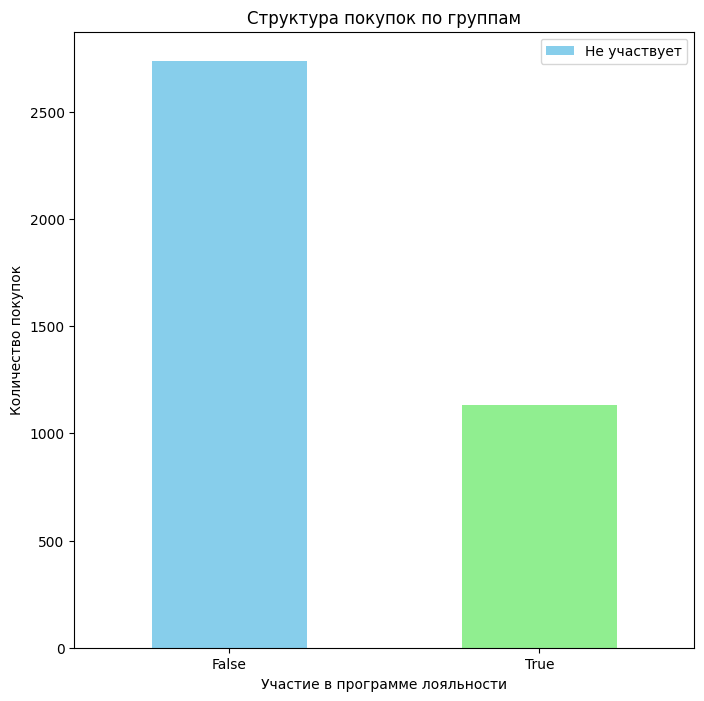

In [24]:
# Группировка данных по участию в программе лояльности
grouped_data = df.groupby('loyalty_program')

# Количество покупок в каждой группе
purchase_count = grouped_data['purchase_id'].nunique()

# График количества покупок в каждой группе
plt.figure(figsize=(8, 8))
purchase_count.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.xlabel('Участие в программе лояльности')
plt.ylabel('Количество покупок')
plt.title('Структура покупок по группам')
plt.xticks(rotation=0)
plt.legend(['Не участвует', 'Участвует'])
plt.show()

#### Выводы: 
В программе лояльности количество покупок меньше, чем у покупателей без нее. 

### Вычислить общую выручку за весь период. Построить график.

In [25]:
#Определяем период данных
date_min = df['purchase_date'].min()
print(date_min)
date_max = df['purchase_date'].max()
print(date_max)

2016-12-01 00:00:00
2017-02-28 00:00:00


In [26]:
# Вычисление общей выручки за весь период
total_revenue = df['revenue'].sum()
print("Общая выручка за весь период:", total_revenue.round(0))

Общая выручка за весь период: 2262658.0


In [27]:
# Расчет месяца покупки
df['purchase_month'] = df['purchase_date'].dt.month

# Группировка и суммирование выручки по месяцам
monthly_revenue = df.groupby('purchase_month')['revenue'].sum()
monthly_revenue = monthly_revenue.sort_values(ascending=False)

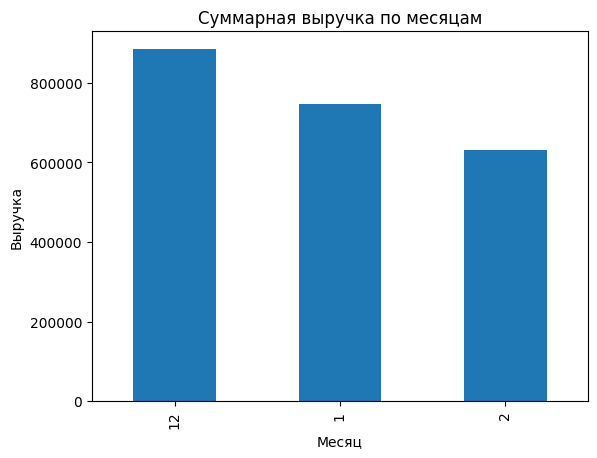

In [28]:
# График суммарной выручки по месяцам
monthly_revenue.plot(kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.title('Суммарная выручка по месяцам')
plt.show()

In [29]:
# Группировка данных по дням и подсчет выручки
daily_revenue = df.groupby(df['purchase_date'].dt.date)['revenue'].sum()

# Создание графика
fig = px.bar(x=daily_revenue.index, y=daily_revenue, labels={'x': 'Дата', 'y': 'Выручка'})
fig.update_layout(title='Выручка по дням')
fig.show()

In [30]:
daily_revenue.describe()

count       68.000000
mean     33274.380066
std      17225.312827
min       4419.251036
25%      21661.791249
50%      28637.814210
75%      44207.113971
max      75631.697061
Name: revenue, dtype: float64

#### Вывод.
Период данных - с 01.12.2016 по 28.02.2017.

Общая выручка за весь период составила 2262658.0 у.е.

По столбчатому графику видим, что самая большая выручка в декабре и самая маленькая в феврале. 

По второму столбчатому графику видим, что есть дни, в которых выручка нулевая (можно предположить, что магазины не работали). 

Средняя выручка в сутки составила 33274 у.е., максимальная - 75631 у.е.

### Построим график активности покупателей.

In [31]:
# Группировка данных по дате и подсчет количества уникальных покупателей
customer_activity = df.groupby('purchase_date')['customer_id'].nunique()

# Создание графика
fig = px.bar(x=customer_activity.index, y=customer_activity, labels={'x': 'Дата', 'y': 'Количество покупателей'})
fig.update_layout(title='Активности покупателей по датам')
fig.show()

#### Вывод.
По графику видно, что самое большое количество покупателей приходится на декабрь. И нет посетителей в первые дни января, ввиду праздников и возможного закрытия магазинов. Также есть и другие дни, в которых нет покупателей, скорее всего это выходные. 

### Сделать анализ магазинов, покупателей. 

#### Анализ магазинов

In [32]:
# Группировка данных по магазинам и вычисление суммарной выручки
shop_revenue = df.groupby('shop_id')['revenue'].sum()

# Создание таблицы с анализом магазинов
shop_analysis = pd.DataFrame({
    'shop_id': shop_revenue.index,
    'total_revenue': shop_revenue.values
})
shop_analysis['total_revenue'] = shop_analysis['total_revenue'].round(2)
# Сортировка таблицы по убыванию выручки
shop_analysis = shop_analysis.sort_values(by='total_revenue', ascending=False)

In [33]:
#Построим график распределения выручки по магазинам
fig = px.bar(shop_analysis,
             x='shop_id',
             y='total_revenue',
             text='total_revenue',
             color='shop_id'
            )

fig.update_layout(title='Распределение выручки по магазинам',
                   yaxis_title='Сумма выручки',
                   xaxis_title='Магазины',
                   showlegend=False,
                   xaxis={'categoryorder':'total descending'}
                 )
fig.show()

**Вывод**

Самый крупный из них по выручке - Shop 0. Выручка за изучаемый период в нем составила 1,82 М у.е.

В тройку лучших по выручке входит:
Shop 3: 104097 у.е.
Shop 6: 62930 у.е.

#### Проанализируем средний чек по магазинам

In [34]:
# Рассчет среднего чека по магазинам
average_check = df.groupby('shop_id')['revenue'].sum() / df.groupby('shop_id')['purchase_id'].nunique()

# Создание новой таблицы с результатами
average_check_table = pd.DataFrame({'shop_id': average_check.index, 'average_check': average_check.values})

# Сортировка таблицы по убыванию среднего чека
average_check_table = average_check_table.sort_values('average_check', ascending=False).round(2)

In [35]:
#Построим график среднего чека по магазинам
fig = px.bar(average_check_table,
             x='shop_id',
             y='average_check',
             text='average_check',
             color='shop_id'
            )

fig.update_layout(title='Средний чек по магазинам',
                   yaxis_title='Сумма чека',
                   xaxis_title='Магазины',
                   showlegend=False,
                   xaxis={'categoryorder':'total descending'}
                 )
fig.show()

**Вывод**

Самый крупный из них по сумме среднего чека - Shop 3. Она в нем составила 8007 у.е.

В тройку лучших входят:
Shop 14: 5376 у.е.
Shop 24: 3917 у.е.

#### Проанализируем количество покупок по магазинам

In [36]:
purchase_counts = df.groupby('shop_id')['purchase_id'].nunique().reset_index()
purchase_counts.columns = ['shop_id', 'purchase_count']

In [37]:
#Построим график количества покупок по магазинам
fig = px.bar(purchase_counts,
             x='shop_id',
             y='purchase_count',
             text='purchase_count',
             color='shop_id'
            )

fig.update_layout(title='Количество покупок по магазинам',
                   yaxis_title='Количество покупок',
                   xaxis_title='Магазины',
                   showlegend=False,
                   xaxis={'categoryorder':'total descending'}
                 )
fig.show()

**Вывод**

Самое большое количество покупателей также у Shop 0. Пришло 3377 клиентов.

В остальных магазинах количество покупателей незначительно.

### Общий вывод.
Количество уникальных покупателей: 1680
Количество уникальных магазинов: 31
Количество уникальных товаров: 3101
Количество уникальных чеков: 3868


Период данных - с 01.12.2016 по 28.02.2017.

Общая выручка за весь период составила 2262658.0 у.е.

По столбчатому графику видим, что самая большая выручка в декабре и самая маленькая в феврале. 

По второму столбчатому графику видим, что есть дни, в которых выручка нулевая (можно предположить, что магазины не работали). 

Средняя выручка в сутки составила 33274 у.е., максимальная - 75631 у.е.

Cамое большое количество покупателей приходится на декабрь. И нет посетителей в первые дни января, ввиду праздников и возможного закрытия магазинов. Также есть и другие дни, в которых нет покупателей, скорее всего это выходные. 

У нас 31 магазин.

Самый крупный из них по выручке - Shop 0. Выручка за изучаемый период в нем составила 1,82 М у.е.

В тройку лучших по выручке входит:
Shop 3: 104097 у.е.
Shop 6: 62930 у.е.

У остальных она меньше.

Самый крупный из них по сумме среднего чека - Shop 3. Она в нем составила 8007 у.е.

В тройку лучших входят:
Shop 14: 5376 у.е.
Shop 24: 3917 у.е.

Самое большое количество покупателей также у Shop 0. Пришло 3377 клиентов.

В остальных магазинах количество покупателей незначительно.

## Провести анализ программы лояльности, расчет бизнес-метрик:
### Вычислить долю участников программы в общем количестве покупателей.

In [38]:
loyalty_customer = df.groupby('loyalty_program')['customer_id'].nunique().reset_index()
loyalty_customer

,loyalty_program,customer_id
0,False,1116
1,True,564


In [39]:
fig = go.Figure(data=[go.Pie(labels=['Без карты', 'С картой'], values=loyalty_customer['customer_id'])], layout=go.Layout(
        title=go.layout.Title(text="Доля клиентов, участвующих в программе лояльности")))
fig.show()

**Вывод**

В программе лояльности участвует 560 человек. Это составляет 33,6% от всех покупателей.

### Вычислить магазины, в которых есть программа лояльности.

In [40]:
loyalty_shops = df[df['loyalty_program'] == 1]['shop_id'].unique()
display(loyalty_shops)

array(['Shop 0', 'Shop 8', 'Shop 28', 'Shop 19'], dtype=object)

**Вывод**

В программе лояльности участвует 4 магазина. Это Shop 0, 'Shop 28', 'Shop 8', 'Shop 19'.

### Проанализируем выручку магазинов в зависимости от программы лояльности или ее отсутствии.

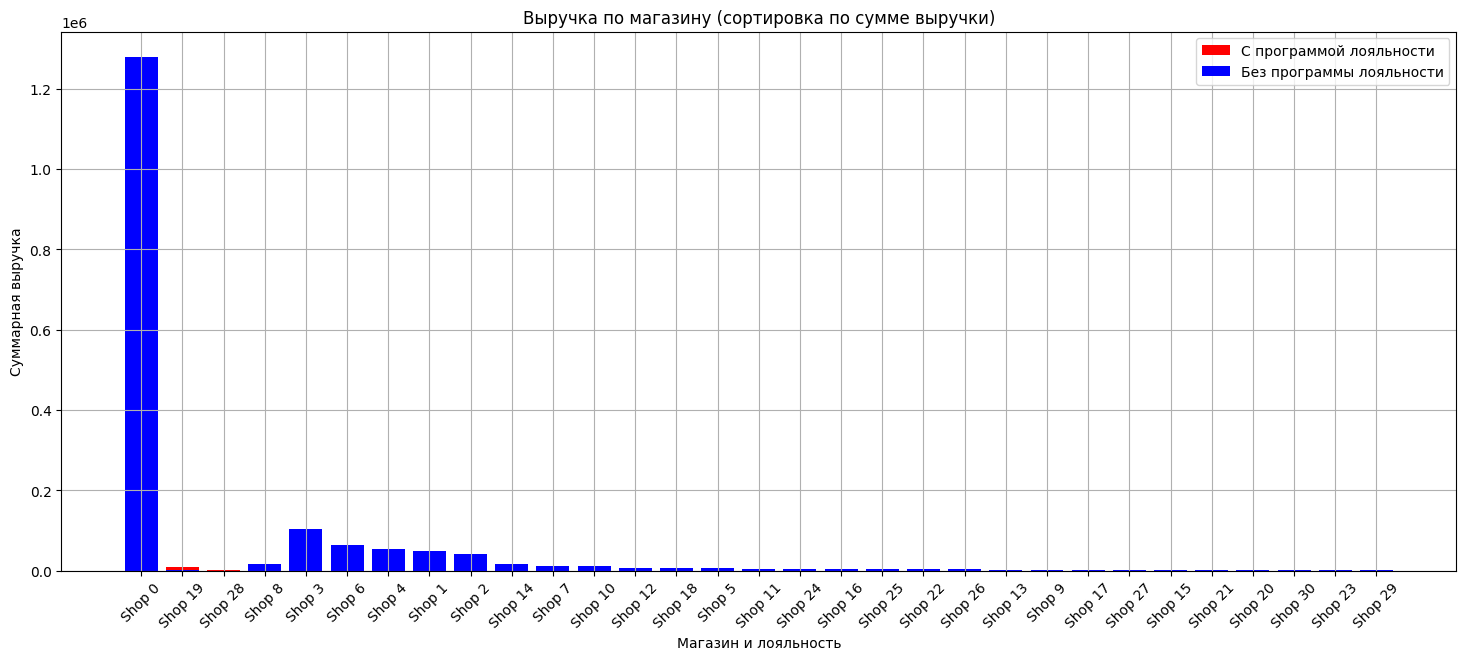

In [41]:
loyalty_revenue = df[df['loyalty_program'] == 1].groupby('shop_id')['revenue'].sum()
non_loyalty_revenue = df[df['loyalty_program'] == 0].groupby('shop_id')['revenue'].sum()

sorted_loyalty_revenue = sorted(loyalty_revenue.items(), key=lambda x: x[1], reverse=True)
sorted_non_loyalty_revenue = sorted(non_loyalty_revenue.items(), key=lambda x: x[1], reverse=True)

shops_loyalty = [item[0] for item in sorted_loyalty_revenue]
revenue_loyalty = [item[1] for item in sorted_loyalty_revenue]

shops_non_loyalty = [item[0] for item in sorted_non_loyalty_revenue]
revenue_non_loyalty = [item[1] for item in sorted_non_loyalty_revenue]

fig, ax = plt.subplots(figsize=(18, 7))
ax.bar(shops_loyalty, revenue_loyalty, color='red', label='С программой лояльности')
ax.bar(shops_non_loyalty, revenue_non_loyalty, color='blue', label='Без программы лояльности')

ax.set_title('Выручка по магазину (сортировка по сумме выручки)')
ax.set_xlabel('Магазин и лояльность')
ax.set_ylabel('Суммарная выручка')
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)

plt.show()

**Вывод**

Суммарная выручка с программой лояльности несущественна и еле видна на графике.

### Сравним средний(медианный) чек по группам(с картой/без)

In [42]:
# Рассчитываем средний(медианный) чек по месяцам
median_purchase= df.groupby(['purchase_date','purchase_id', 'loyalty_program']).agg({'revenue':'sum'}).reset_index()
median_purchase= median_purchase.groupby(['purchase_date','loyalty_program']).agg({'revenue':'median'}).reset_index()
# Построение графика медианного чека
fig = px.bar(median_purchase, 
             x='purchase_date', 
             y='revenue', 
             text='revenue',
             color='loyalty_program',
             barmode='group'
            )

fig.update_layout(title='Медианный чек по месяцам',
                   xaxis_title='Месяц',
                   yaxis_title='Медианная сумма чека',
                  xaxis={'categoryorder':'total descending'}
                 )
fig.show()

**Вывод**

Во всех месяцах за три месяца медианный чек у клиентов с картой выше, чем у клиентов без.

###  LTV клиента (с картой/без). Посмотрим динамику повторных покупок.

In [43]:
# функция для получения расширенных пользовательских профилей
def get_profiles(df):

    # находим параметры первых посещений
    profiles = (
        df.sort_values(by=['customer_id', 'purchase_date'])
        .groupby('customer_id')
        .agg(
            {
                'purchase_date': 'first',
                'loyalty_program': 'first',
                'shop_id': 'first',
            }
        )
        .rename(columns={'purchase_date': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'loyalty_program'])
        .agg({'customer_id': 'nunique'})
        .rename(columns={'customer_id': 'unique_customer'})
        .reset_index()
    )

    new_users['dt'] = pd.to_datetime(new_users['dt'])

    return profiles

In [44]:
# строим профили по двум наборам данных
profiles = get_profiles(df)

# доступный интервал привлечения пользователей
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()  # момент анализа
    
display(profiles.head(10))
print(min_analysis_date)
print(observation_date)

,customer_id,first_ts,loyalty_program,shop_id,dt,month
0,0,2016-12-01,False,Shop 0,2016-12-01,2016-12-01
1,18026,2016-12-07,False,Shop 15,2016-12-07,2016-12-07
2,18027,2016-12-16,False,Shop 22,2016-12-16,2016-12-16
3,18029,2017-02-02,False,Shop 5,2017-02-02,2017-02-02
4,18031,2017-02-16,False,Shop 5,2017-02-16,2017-02-16
5,18035,2017-01-18,False,Shop 10,2017-01-18,2017-01-18
6,18038,2017-01-12,False,Shop 18,2017-01-12,2017-01-12
7,18040,2017-02-25,False,Shop 12,2017-02-25,2017-02-25
8,18041,2017-02-17,False,Shop 12,2017-02-17,2017-02-17
9,18044,2017-02-21,False,Shop 18,2017-02-21,2017-02-21


2016-12-01
2017-02-28


In [45]:
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['customer_id', 'purchase_date', 'revenue']],
        on='customer_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['purchase_date'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    # добавляем стоимость подписки в каждый первый доступный день месяца
    loyalty_rows = result_raw[result_raw['loyalty_program'] == True]
    first_month_date = loyalty_rows.groupby(['customer_id', 'month'])['dt'].min()
    first_month_date_index = list(first_month_date.index)

    for customer_id, month in first_month_date_index:
        result_raw.loc[(result_raw['customer_id'] == customer_id) & (result_raw['month'] == month), 'revenue'] += 200

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 4. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 5. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 6. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'customer_id': 'nunique'})
            .rename(columns={'customer_id': 'cohort_size'})
        )

        # Шаг 7. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 8. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики LTV убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

In [46]:
#Собираем данные
purchases = df.groupby(['customer_id', 'purchase_date']).agg({'revenue':'sum'}).reset_index()
purchases

,customer_id,purchase_date,revenue
0,0,2016-12-01,5427.464343
1,0,2016-12-02,412.183778
2,0,2016-12-03,12156.558298
3,0,2016-12-05,0.000000
4,0,2016-12-06,10075.745609
...,...,...,...
3147,23939,2017-01-09,738.457202
3148,23948,2016-12-08,197.537500
3149,23962,2017-01-06,12.361000
3150,23962,2017-01-23,37.242500


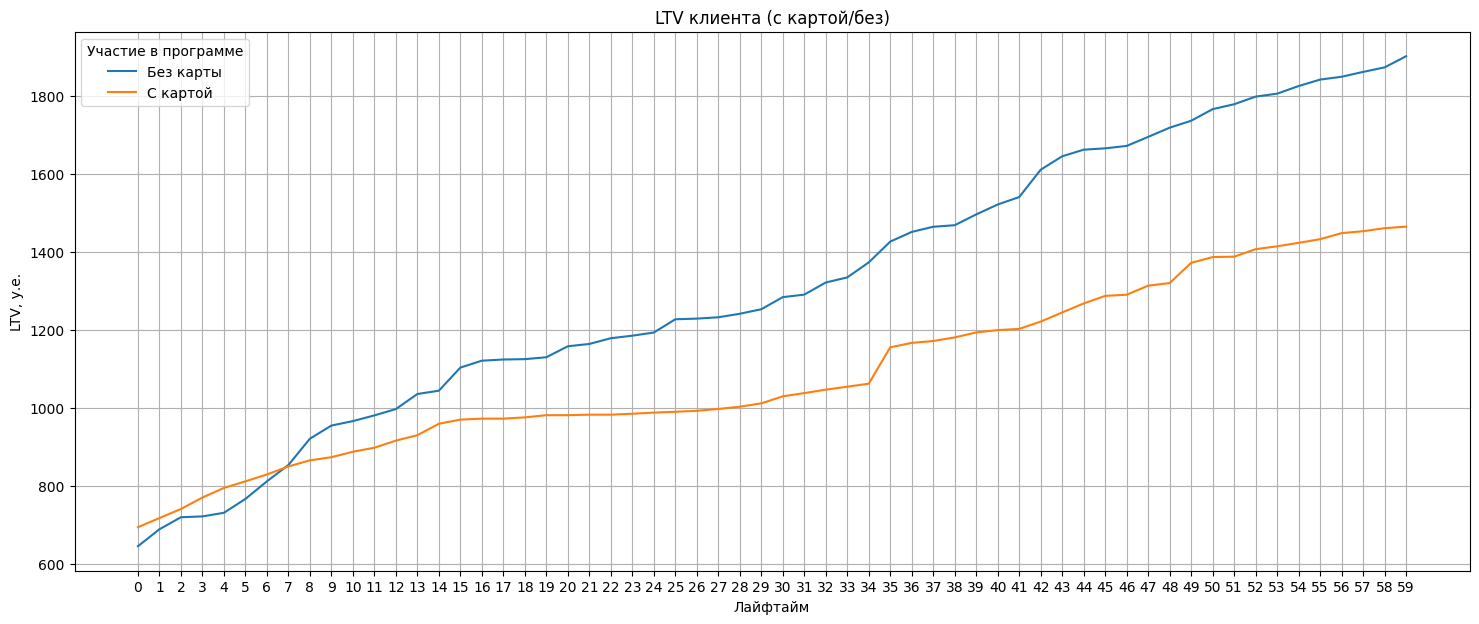

In [47]:
ltv_raw, ltv, ltv_history = get_ltv(profiles, purchases, datetime(2017, 2, 28).date(), 60, dimensions=['loyalty_program'])

report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(18, 7), xticks=list(report.columns.values))
plt.title('LTV клиента (с картой/без)')
plt.ylabel('LTV, у.е.')
plt.xlabel('Лайфтайм')
plt.legend(title='Участие в программе', labels=['Без карты','С картой'])
plt.show()

**Вывод**

Судя по графику, LTV у пользователей с картой в самом начале превышало, но потом у пользователей без карты стало выше, и тренд сохранился.

### Вывод.

В программе лояльности участвует 560 человек. Это составляет 33,6% от всех покупателей.

Данная акция запущена в 4 магазинах. Это Shop 0, 'Shop 28', 'Shop 8', 'Shop 19'

Расчеты производились с учетом дополнительной оплаты программы лояльности клиентами. Если считать без нее, то показатели будут хуже.

Средний(медианный) чек у клиентов c картой лояльности выше, чем без нее.

LTV у пользователей с картой выше, чем без. Поэтому вывод, что общую сумму денег, которую один клиент в среднем приносит компании со всех своих покупок больше - хороший показатель.

Считаю, что программа лояльности работает и будет дальше улучшать показатели. Клиенты с картами лояльности пприносят больше выручки(средний чек выше).

## Сформулировать и проверить статистические гипотезы:

### Проверить гипотезу: средний чек в декабре участников программы лояльности выше, чем у остальных покупателей. Для проверки гипотезы можно использовать t-тест Стьюдента.

**Гипотезы:**

Н0 - средний чек в декабре у покупателей с программой лояльности и без программы лояльности равны.

Н1 - средние чеки не равны.

In [48]:
    # Агрегируем и фильтруем данные по декабрю
    december_check = (df[df['purchase_month'] == 12]
                    .groupby(['loyalty_program','purchase_id','purchase_date'])
                    .agg({'revenue':'sum'}).reset_index())


    # Проводим t-тест
    p_value = stats.ttest_ind(december_check[december_check['loyalty_program']==True]['revenue'], 
                              december_check[december_check['loyalty_program']==False]['revenue'])[1]

    # Определяем уровень значимости
    alpha = 0.05

    print('p-значение:', p_value)

    # Проверка статистической значимости результатов
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу. Средние чеки не равны.")
    else:
        print("Не получилось отвергнуть нулевую гипотезу. Средние чеки равны.")

p-значение: 0.008922176986894991
Отвергаем нулевую гипотезу. Средние чеки не равны.


**Вывод**

У нас подтвердилась гипотеза о том, что средние чеки не равны. У лояльных клиентов они выше. До этого мы строили график и он это тоже наглядно показывал.

###  Проверить гипотезу: доля покупок в декабре в чеке у участников программы лояльности значимо выше, чем у неучастников.

**Гипотезы:**
    
Н0 - доля покупок в декабре в чеке с картой и без карты равно.

Н1 - доля покупок в декабре в чеке с картой и без карты не равны.

In [49]:
# Агрегируем и фильтруем данные по декабрю
december_purchase = (df[df['purchase_month'] == 12]
                     .groupby(['loyalty_program'])
                     .agg({'purchase_id':'nunique'}).reset_index())
total_purchase = (df.groupby(['loyalty_program'])
                     .agg({'purchase_id':'nunique'}).reset_index())
# Подсчет количества покупок с картой в декабре
with_card_count_december = december_purchase['purchase_id'][1]
# Подсчет количества покупок без карты в декабре
without_card_count_december = december_purchase['purchase_id'][0]
# Подсчет общего количества покупок c картой
with_card_count = total_purchase['purchase_id'][1]
# Подсчет общего количества покупок без карты
without_card_count = total_purchase['purchase_id'][0]
purchases = np.array([with_card_count_december, without_card_count_december])
leads = np.array([with_card_count, without_card_count])

# пропорция успехов в первой группе:
p1 = purchases[0] / leads[0]
# пропорция успехов во второй группе:
p2 = purchases[1] / leads[1]
# пропорция успехов в комбинированном датасете:
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
# разница пропорций в датасетах
difference = p1 - p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / leads[0] + 1 / leads[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение:', p_value)
alpha = 0.05
# Проверка статистической значимости результатов
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Доли покупок в декабре в чеке с картой и без карты не равны.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Доля покупок в декабре в чеке с картой и без карты равны.")

p-значение: 0.012613043836771753
Отвергаем нулевую гипотезу. Доли покупок в декабре в чеке с картой и без карты не равны.


**Вывод**

Доля покупок в декабре в чеке с картой и без карты не равны. У лояльных клиентов доля покупок больше.

###  Проверить гипотезу: доля пользователей совершивших повторную покупку в группе лояльности и без не отличается.

**Гипотезы:**
    
Н0 - доля пользователей совершивших повторную покупку с картой и без карты равно.

Н1 - доля пользователей совершивших повторную покупку с картой и без карты не равны.

In [50]:
# Сгруппируем данные
purchase_without_card = (df[df['loyalty_program'] == False]
                         .groupby('customer_id')
                         .agg({'purchase_id':'nunique'}).reset_index())
purchase_with_card = (df[df['loyalty_program'] == True]
                      .groupby('customer_id')
                      .agg({'purchase_id':'nunique'}).reset_index())

purchases = np.array([purchase_without_card[purchase_without_card['purchase_id'] > 1]['purchase_id'].sum(), 
                      purchase_with_card[purchase_with_card['purchase_id'] > 1]['purchase_id'].sum()])
leads = np.array([purchase_without_card['purchase_id'].sum(), 
                  purchase_with_card['purchase_id'].sum()])


# пропорция успехов в первой группе:
p1 = purchases[0] / leads[0]
# пропорция успехов во второй группе:
p2 = purchases[1] / leads[1]
# пропорция успехов в комбинированном датасете:
p_combined = (purchases[0] + purchases[1]) / (leads[0] + leads[1])
# разница пропорций в датасетах
difference = p1 - p2
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / leads[0] + 1 / leads[1]))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение:', p_value)
alpha = 0.05

# Проверьте статистическую значимость результатов
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Доли пользователей совершивших повторную покупку с картой и без карты не равны.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Доли пользователей совершивших повторную покупку с картой и без карты равны.")

p-значение: 0.0907885411606959
Не получилось отвергнуть нулевую гипотезу. Доли пользователей совершивших повторную покупку с картой и без карты равны.


**Вывод**
 
Доли пользователей совершивших повторную покупку с картой и без карты равны.

## Сформулировать выводы и рекомендации по результатам анализа данных:

### Вывод:

Количество уникальных покупателей: 1680
Количество уникальных магазинов: 31
Количество уникальных товаров: 3101
Количество уникальных чеков: 3868


Период данных - с 01.12.2016 по 28.02.2017.

Общая выручка за весь период составила 2262658.0 у.е.

По столбчатому графику видим, что самая большая выручка в декабре и самая маленькая в феврале. 

По второму столбчатому графику видим, что есть дни, в которых выручка нулевая (можно предположить, что магазины не работали). 

Средняя выручка в сутки составила 33274 у.е., максимальная - 75631 у.е.

Cамое большое количество покупателей приходится на декабрь. И нет посетителей в первые дни января, ввиду праздников и возможного закрытия магазинов. Также есть и другие дни, в которых нет покупателей, скорее всего это выходные. 

У нас 31 магазин.

Самый крупный из них по выручке - Shop 0. Выручка за изучаемый период в нем составила 1,82 М у.е.

В тройку лучших по выручке входит:
Shop 3: 104097 у.е.
Shop 6: 62930 у.е.

У остальных она меньше.

Самый крупный из них по сумме среднего чека - Shop 3. Она в нем составила 8007 у.е.

В тройку лучших входят:
Shop 14: 5376 у.е.
Shop 24: 3917 у.е.

Самое большое количество покупателей также у Shop 0. Пришло 3377 клиентов.

В остальных магазинах количество покупателей незначительно.

В программе лояльности участвует 560 человек. Это составляет 33,6% от всех покупателей.

Данная акция запущена в 4 магазинах. Это Shop 0, 'Shop 28', 'Shop 8', 'Shop 19'.

Средний(медианный) чек у клиентов c картой лояльности выше, чем без нее.

LTV у пользователей с картой ниже, чем с картой. Поэтому вывод, что общую сумму денег приносят компании клиенты без программы лояльности.

Считаю, что программа лояльности работает, но пока недостаточно эффективно.

После проверки гипотез сделаем вывод: программа работает, но не во всем. Средний чек у участников программы лояльности выше, чем не у лояльных. В декабре доля покупок больше у лояльных клиентов, чем не у лояльных.

### Дать рекомендации по улучшению программы лояльности и ее эффективности.
Распространить программу лояльности на другие магазины сети. Пока она есть только у 4 магазинов.
Следует посмотреть данные за более продолжительный период и так как магазины строительные, то лучше учесть данные за летний период.
Понять как программа лояльности действует на оптовые заказы, если таковые есть.
Проанализировать финансовую деятельность всех магазинов, так как основную часть выручки приносит один.

Дашборд - https://public.tableau.com/app/profile/sergei.iurinov/viz/Retail_16850011250550/Dashboard2?publish=yes

Презентация - https://disk.yandex.ru/i/3W9NeBZ9THMbBg